In [449]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, hilbert

In [477]:
""" Coverting string to bitstream """
original_msg = "Test string showing zero bit errors."
original_bitstring = ''.join(format(ord(x), '08b') for x in original_msg)
original_bitstream = [int(b) for b in original_bitstring]

In [478]:
""" Encoding bits into waves """
bit_rate = 600
bit_time = 1 / bit_rate
sample_rate = 10000
samples_per_bit = int(bit_time * sample_rate)

t_bit = np.linspace(0, bit_time, int(sample_rate * bit_time), endpoint=False)

f0 = 1000
f0_wave_ref = np.sin(2*np.pi * f0 * t_bit)

f1 = 1500
f1_wave_ref = np.sin(2*np.pi * f1 * t_bit)

waveform = []

# FSK Modulation
for bit in original_bitstream:
    freq = f0 if bit == 0 else f1
    wave = np.sin(2*np.pi * freq * t_bit)
    waveform.append(wave)

# # ASK Modulation
# for bit in original_bitstream:
#     amp = 0.2 if bit == 0 else 1.0
#     wave = amp * np.sin(2*np.pi * f0 * t_bit)
#     waveform.append(wave)

# # BPSK Modulation
# for bit in original_bitstream:
#     phase = 1 if bit == 0 else -1
#     wave = phase * np.sin(2*np.pi * f0 * t_bit)
#     waveform.append(wave)

waveform = np.concatenate(waveform)
n_bits = len(waveform) / samples_per_bit

(0.0, 0.03)

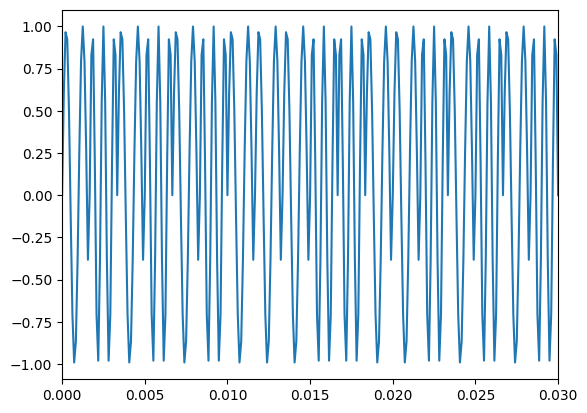

In [479]:
""" Plotting partial coded stream """
total_time = np.linspace(0, bit_time * len(original_bitstream), len(waveform), endpoint=False)
plt.plot(total_time, waveform)
plt.xlim(0, 0.03)

In [480]:
""" Classifying which modulation method was used """
# Function for adding noise 
def add_noise(waveform, snr_db):
    signal_power = np.mean(waveform ** 2) # Mean of amplitude squared
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    noise = np.random.normal(0, np.sqrt(noise_power), size=waveform.shape) # Power = std ** 2 -> np.sqrt(noise_power)
    return (waveform + noise)


# Finding peaks in the encoded waveform 
def get_dominant_frequencies(waveform, sample_rate, samples_per_bit):
    n_bits = len(waveform) // samples_per_bit
    freqs = np.fft.fftfreq(samples_per_bit, d=1/sample_rate)

    dom_freqs = []
    for i in range(n_bits):
        segment = waveform[i*samples_per_bit:(i+1)*samples_per_bit]
        fft_results = np.fft.rfft(segment)
        spectrum = np.abs(fft_results)
        
        dominant_freq = freqs[np.argmax(spectrum)]
        dom_freqs.append(dominant_freq)
            
    return np.array(dom_freqs)


def detect_fsk(dom_freqs, tolerance=20):
    buckets = np.round(dom_freqs / tolerance) * tolerance

    return len(np.unique(buckets)) > 1


def detect_ask_bpsk(waveform, sample_rate, amp_threshold=0.3, phase_jump_thresh=np.pi/2):
    analytic = hilbert(waveform)
    inst_amp = np.abs(analytic)
    inst_phase = np.unwrap(np.angle(analytic))
    amp_std = np.std(inst_amp)

    jumps = np.diff(inst_phase)
    n_jumps = 0
    for jump in jumps:
        if np.abs(jump) > phase_jump_thresh:
            n_jumps += 1

    if amp_std > amp_threshold:
        return 'ASK'

    elif n_jumps > 0:
        return 'BPSK'
    else:
        return 'Unknown'


def classify_modulation(waveform, sample_rate, samples_per_bit):
    dom_freqs = get_dominant_frequencies(waveform, sample_rate, samples_per_bit)
    if detect_fsk(dom_freqs):
        return 'FSK'

    return detect_ask_bpsk(waveform, sample_rate)

In [481]:
""" Adding noise to wave and running modulation classification """
snr_db = 4
noisy_waveform = add_noise(waveform, snr_db)
    
mod_type = classify_modulation(noisy_waveform, sample_rate, samples_per_bit)
print(f"Detected {mod_type} modulation type")

Detected FSK modulation type


In [482]:
""" Function for decoding wave using FSK, ASK, and BPSK """
def decode_fsk(waveform, f0_wave_ref, f1_wave_ref, samples_per_bit):
    decoded_bitstream = []
    for start in range(0, len(waveform), samples_per_bit):
        segment = waveform[start: start + samples_per_bit]
        
        f0_cor = np.dot(segment, f0_wave_ref) # Correlation
        f1_cor = np.dot(segment, f1_wave_ref) 
    
        bit = 0 if abs(f0_cor) > abs(f1_cor) else 1
        decoded_bitstream.append(bit)

    return decoded_bitstream
    

def decode_ask(waveform, wave_ref, samples_per_bit):
    decoded_bitstream = []
    correlations = []
    
    for start in range(0, len(waveform), samples_per_bit):
        segment = waveform[start: start + samples_per_bit]
        correlation = np.dot(segment, wave_ref)
        correlations.append(correlation)

    # Adaptive thresholding
    min_corr = np.min(correlations)
    max_corr = np.max(correlations)
    threshold = (min_corr + max_corr) / 2

    for c in correlations:
        bit = 1 if abs(c) > threshold else 0
        decoded_bitstream.append(bit)
        
    return decoded_bitstream
    

def decode_bpsk(waveform, wave_ref, samples_per_bit):
    decoded_bitstream = []
    for start in range(0, len(waveform), samples_per_bit):
        segment = waveform[start: start + samples_per_bit]
        
        phase_sign = np.dot(segment, wave_ref)
    
        bit = 0 if phase_sign > 0 else 1
        decoded_bitstream.append(bit)

        cor = np.dot(segment, wave_ref)

        
    return decoded_bitstream

In [483]:
""" Decoding bitstream """
if mod_type == 'FSK':
    decoded_bitstream = decode_fsk(noisy_waveform, f0_wave_ref, f1_wave_ref, samples_per_bit)
elif mod_type == 'ASK':
    decoded_bitstream = decode_ask(noisy_waveform, f0_wave_ref, samples_per_bit)
elif mod_type == 'BPSK':
    decoded_bitstream = decode_bpsk(noisy_waveform, f0_wave_ref, samples_per_bit)
else:
    raise ValueError("Unrecognised modulation type")

In [484]:
""" Function for calculating bit error """
def calculate_ber(original_bitstream, decoded_bitstream):
    decoded_bitstream = decoded_bitstream[:len(original_bitstream)]

    bit_errors = np.sum(np.array(original_bitstream) != np.array(decoded_bitstream))
    ber = bit_errors / len(original_bitstream)
    return ber

In [485]:
""" Decoding bitstream and finding bit error for varying SNR """
snr_values_db = np.arange(-5, 21, 2)
ber_values = []

for snr in snr_values_db:
    noisy_wave = add_noise(waveform, snr)

    if mod_type == 'FSK':
        decoded_bitstream = decode_fsk(noisy_waveform, f0_wave_ref, f1_wave_ref, samples_per_bit)
    elif mod_type == 'ASK':
        decoded_bitstream = decode_ask(noisy_waveform, f0_wave_ref, samples_per_bit)
    elif mod_type == 'BPSK':
        decoded_bitstream = decode_bpsk(noisy_waveform, f0_wave_ref, samples_per_bit)
    else:
        raise ValueError("Unrecognised modulation type")
    
    ber = calculate_ber(original_bitstream, decoded_bitstream)
    ber_values.append(ber)

In [486]:
""" Checking for errors """
error_count = 0
for d_bit, o_bit in zip(decoded_bitstream, original_bitstream):
    if d_bit != o_bit:
        error_count += 1

print(f"The decoded bitstream has {error_count} error(s)")

The decoded bitstream has 0 error(s)


In [487]:
""" Converting bitstream to text """
def bitstream_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        byte_str = ''.join(str(b) for b in byte)
        decimal_int = int(byte_str, 2) # Converts byte string into a binary number. 2 for only 1, 0 to choose from.
        char = chr(decimal_int) # Converts int into ascii character (e.g. 72 for H)
        chars.append(char)

    return ''.join(chars)

decoded_msg = bitstream_to_text(decoded_bitstream)

In [488]:
""" Summary report """
print("SUMMARY REPORT")
print("\n" + "="*40)
print(f"Modulation Type: {mod_type}")
print(f"Total Bits: {n_bits}")
print(f"Transmission Duration: {np.max(total_time):.4f} seconds")
print(f"Bit Errors: {error_count}")
print(f"Bit Error Rate (BER): {ber:.5f}")
print("\n--- Message Comparison ---")
print(f"Original: {original_msg}")
print(f"Decoded : {decoded_msg}")
print("="*40 + "\n")

SUMMARY REPORT

Modulation Type: FSK
Total Bits: 288.0
Transmission Duration: 0.4799 seconds
Bit Errors: 0
Bit Error Rate (BER): 0.00000

--- Message Comparison ---
Original: Test string showing zero bit errors.
Decoded : Test string showing zero bit errors.



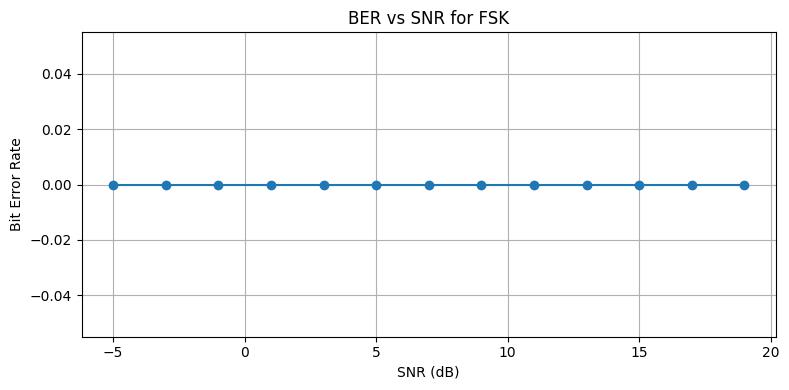

In [489]:
plt.figure(figsize=(8, 4))
plt.plot(snr_values_db, ber_values, marker='o')
plt.title(f"BER vs SNR for {mod_type}")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


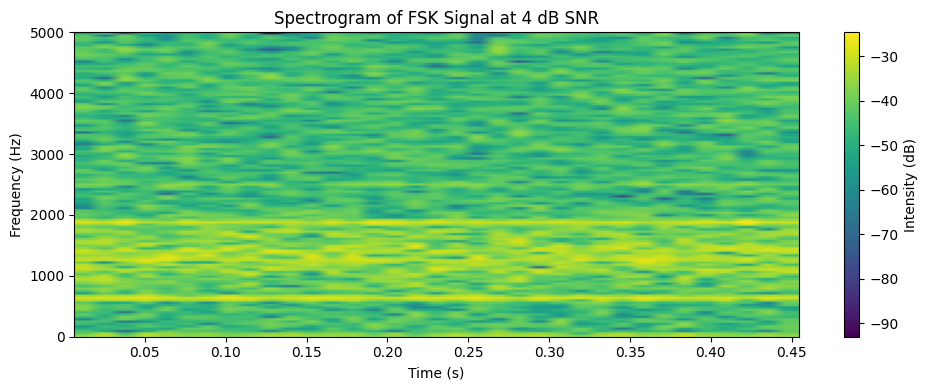

In [490]:
plt.figure(figsize=(10, 4))
plt.specgram(noisy_waveform, NFFT=256, Fs=sample_rate, noverlap=128, cmap='viridis')
plt.title(f"Spectrogram of {mod_type} Signal at {snr_db} dB SNR")
plt.xlabel("Time (s)") 
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.tight_layout()
plt.savefig('fsk-specgram-4dbSNR')
plt.show()
